
# 必要なモジュールのインポート

In [1]:
import random
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

from tqdm import tqdm
import requests as rt
import matplotlib.pyplot as plt

In [2]:
import os

os.cpu_count()

2

In [3]:
torch.__version__

'2.0.0+cu118'

In [4]:
# PyTorchの乱数シード固定方法
# https://take-tech-engineer.com/pytorch-randam-seed-fix/

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


torch_fix_seed()


# CIFAR-10のデータセットを読み込み、訓練データとテストデータを用意するコード

In [5]:
# num_workers=os.cpu_count(), pin_memory=Trueは以下のサイト参考
# https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=os.cpu_count(), pin_memory=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False,
                                         num_workers=os.cpu_count(), pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 26579027.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# dataがカレントディレクトリに保存される
!ls

data  sample_data


# 訓練データの一部を表示するコード

image.shape:  torch.Size([128, 3, 32, 32])


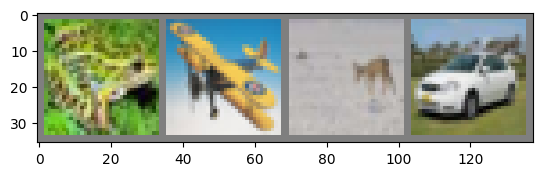

 frog plane  deer   car


In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# torch.manual_seed(42) # これで毎回同じになる

dataiter = iter(trainloader)
images, labels = next(dataiter) # loader作成時にshuffle=Trueとしているので毎回変わる

print('image.shape: ', images.shape)

num_slice = 4

imshow(torchvision.utils.make_grid(images[:num_slice]))
print(' '.join('%5s' % classes[labels[j]] for j in range(num_slice)))

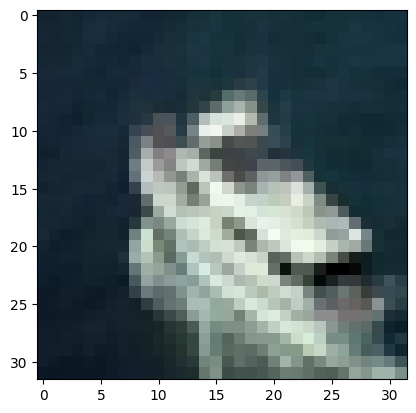

ship


In [9]:
# 一つだけ出力したい場合

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# torch.manual_seed(42) # これで毎回同じになる

dataiter = iter(trainloader)
images, labels = next(dataiter) # loader作成時にshuffle=Trueとしているので毎回変わる

image, label = images[0], labels[0]

imshow(torchvision.utils.make_grid(image))
print(classes[label])

# CNNのクラスを定義するコード。最後にオブジェクトを生成して変数netに格納している

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

net = Net()

# GPUかCPUかを判定するコード

In [11]:
print(torch.cuda.is_available())

True


# torch.deviceオブジェクトを生成するコード。GPUかCPUかは自動判定する

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# CNNのオブジェクトでGPUを使えるようにするコード

In [13]:
net.to(device)

Net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, o

# 損失関数とオプティマイザを定義するコード

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練を実行するコード

In [15]:
# lineの設定
token = "My token"
line = "https://notify-api.line.me/api/notify"
head = {"Authorization": "Bearer " + token}

In [16]:
# https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587
# 高速化処理
torch.backends.cudnn.benchmark = True

In [17]:
num_epoch = 15

train_loader_size = len(trainloader)

train_loss_list = list()

for epoch in tqdm(range(num_epoch)):
    running_train_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # inputs, labels = data # cpu
        inputs, labels = data[0].to(device), data[1].to(device)  # gpu

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss_list.append(running_train_loss / train_loader_size)
    

mes = {"message": "Finished Training"}
rt.post(line, headers=head, data=mes) # lineに通知.

100%|██████████| 15/15 [04:04<00:00, 16.27s/it]


<Response [200]>

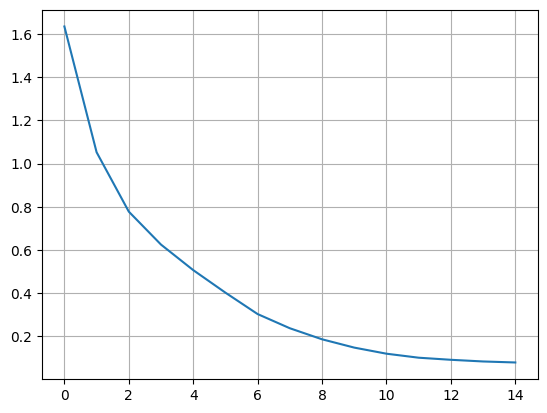

In [18]:
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.grid(True)
plt.show()

# モデルの保存と再度読み込み

In [19]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [20]:
!ls

cifar_net.pth  data  sample_data


In [21]:
# 読み込み

# net = Net()
# net.load_state_dict(torch.load(PATH))

# テスト用データの先頭を取り出して表示するコード

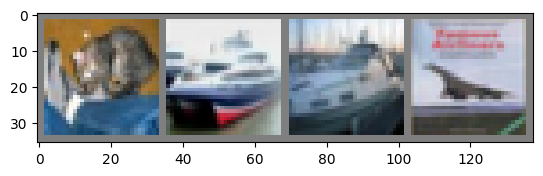

GroundTruth:    cat  ship  ship plane


In [22]:
dataiter = iter(testloader)
images, labels = next(dataiter)

num_slice = 4

imshow(torchvision.utils.make_grid(images[:num_slice]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(num_slice)))

# 先頭のテスト用データを分類するコード

In [23]:
# outputs = net(images) # cpu
outputs = net(images.to(device))  # gpu
_, predicted = torch.max(outputs, 1)

num_slice = 4

print('Predicter: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(num_slice)))

Predicter:    cat  ship  ship plane


# 先頭より後のテスト用データを分類するコード

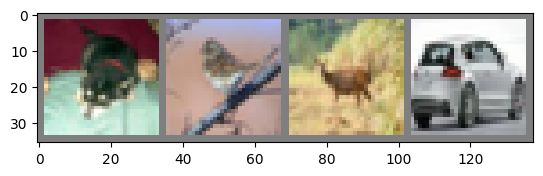

GroundTruth:    dog  bird  deer   car
Predicted:    cat  bird  deer   car


In [24]:
images, labels = next(dataiter)
num_slice = 4
imshow(torchvision.utils.make_grid(images[:num_slice]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(num_slice)))

# outputs = net(images[:num_slice]) # cpu
outputs = net(images[:num_slice].to(device))  # gpu
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(num_slice)))

# 全テストデータの正解率を求めるコード

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # images, labels = data # cpu
        images, labels = data[0].to(device), data[1].to(device)  # gpu
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


# 全テストデータのクラスごとの正解率を求めるコード

In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        # images, labels = data # cpu
        images, labels = data[0].to(device), data[1].to(device)  # gpu
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82 %
Accuracy of   car : 91 %
Accuracy of  bird : 67 %
Accuracy of   cat : 66 %
Accuracy of  deer : 74 %
Accuracy of   dog : 68 %
Accuracy of  frog : 83 %
Accuracy of horse : 81 %
Accuracy of  ship : 90 %
Accuracy of truck : 88 %
